In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

import scanpy as sc
import scanpy.external as sce

from igraph import *
import ipywidgets
from MulticoreTSNE import MulticoreTSNE as TSNE #faster TSNE alternative
import anndata
from anndata import read_h5ad
import arrow
import bbknn
import leidenalg

sc.settings.verbosity = 3
sc.logging.print_versions()
np.random.seed(685)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.set_figure_params(dpi=50)

scanpy==1.4.5.dev147+g724da7d anndata==0.6.22.post2.dev80+g72c2bde numpy==1.17.3 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
adata = read_h5ad('/data/maca/maca-data-release-v4/tabula-muris-senis-facs-official-raw-obj.h5ad')
adata

AnnData object with n_obs × n_vars = 164311 × 23341 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue'

In [6]:
adata.var_names[adata.var_names.str.startswith('Ercc')]

Index(['Ercc1', 'Ercc2', 'Ercc3', 'Ercc4', 'Ercc5', 'Ercc6', 'Ercc6l',
       'Ercc8'],
      dtype='object', name='index')

In [7]:
erccs = adata[:,adata.var_names[adata.var_names.str.startswith('Ercc')]]
erccs

View of AnnData object with n_obs × n_vars = 164311 × 8 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue'

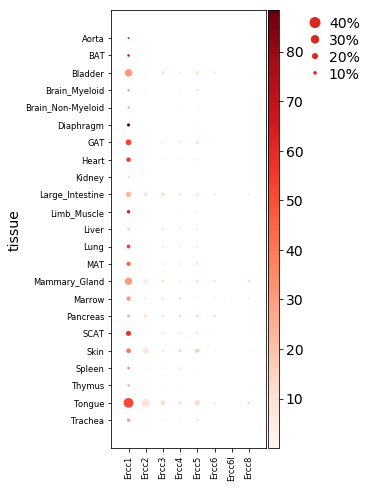

GridSpec(2, 5, height_ratios=[0, 10.5], width_ratios=[2.8, 0, 0.2, 0.5, 0.25])

In [14]:
sc.pl.dotplot(erccs, groupby='tissue',var_names=erccs.var_names)

View of AnnData object with n_obs × n_vars = 110824 × 23335 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes'

remove non-annotated cells


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 110824 × 23335 
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells'

look at quality metrics


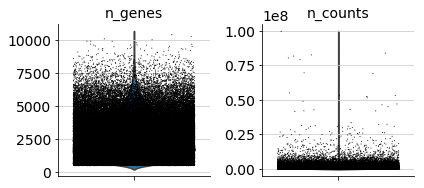

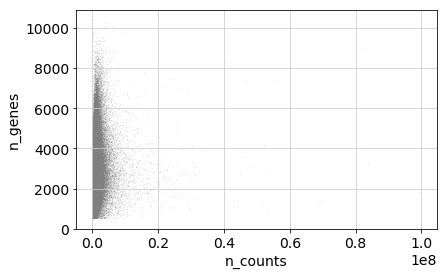

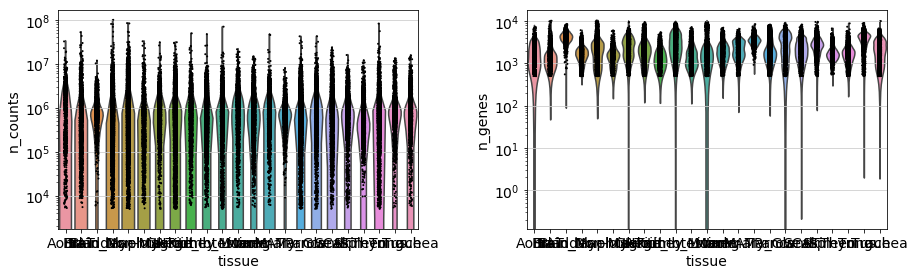

In [16]:
adata = adata[:,:-3]
display(adata)
# AnnData object with n_obs × n_vars = 164311 × 23338 

# print('pre-processing')
# sc.pp.filter_genes(adata, min_cells=3)
# # filtered out 372 genes that are detected in less than 3 cells
# sc.pp.filter_cells(adata, min_genes=250)
# # filtered out 37443 cells that have less than 250 genes expressed
# sc.pp.filter_cells(adata, min_counts=5000)
# # filtered out 4279 cells that have less than 5000 counts
# display(adata)
# # AnnData object with n_obs × n_vars = 122589 × 22966

print('remove non-annotated cells')
adata = adata[adata.obs['cell_ontology_class']!='nan'].copy()
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)
sc.pp.filter_cells(adata, min_counts=0)
display(adata)
# AnnData object with n_obs × n_vars = 110824 × 22966 

print('look at quality metrics')
sc.pl.violin(adata, ['n_genes', 'n_counts'],jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='n_genes')

sc.pl.violin(adata, ['n_counts','n_genes'], groupby='tissue', size=2, log=True)
adata.raw = adata

In [17]:
adata.X.shape

(110824, 23335)

In [18]:
bladder = adata[adata.obs['tissue']=='Bladder']

In [19]:
bladder.X.shape

(2432, 23335)

In [34]:
# bladder.X = bladder.X.todense
bladder.X = bladder.X.todense()
bladder.X

<2432x23335 sparse matrix of type '<class 'numpy.float32'>'
	with 10731885 stored elements in Compressed Sparse Row format>

In [37]:
bladder.X.todense().mean(axis=0).shape, bladder.X.todense().var(axis=0).shape

((1, 23335), (1, 23335))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


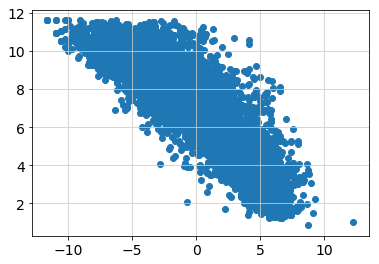

In [228]:
x = np.log(np.array(adata.X.todense().mean(axis=0).transpose()).flatten())
y = np.log(np.array(adata.X.todense().var(axis=0).transpose()).flatten()/np.array(adata.X.todense().mean(axis=0).transpose()).flatten()**2)
x = x[y==y]
gene_names = adata.var_names[y==y]
y = y[y==y]
plt.scatter(x,y)


In [161]:
a = y<4
a = a.astype(int)
b = x<4
b = b.astype(int)
c = x>-2
c = c.astype(int)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [162]:
z = list(set(adata.var_names[a*b==1]))
z.sort()
z

['0610007N19Rik',
 '0610007P08Rik',
 '0610007P14Rik',
 '0610007P22Rik',
 '0610009B22Rik',
 '0610009L18Rik',
 '0610009O20Rik',
 '0610010F05Rik',
 '0610010K14Rik',
 '0610011L14Rik',
 '0610012G03Rik',
 '0610030E20Rik',
 '0610038B21Rik',
 '0910001L09Rik',
 '100043387',
 '1110001A16Rik',
 '1110001J03Rik',
 '1110002N22Rik',
 '1110004E09Rik',
 '1110005A03Rik',
 '1110007C09Rik',
 '1110008J03Rik',
 '1110008L16Rik',
 '1110008P14Rik',
 '1110012J17Rik',
 '1110012L19Rik',
 '1110014N23Rik',
 '1110017F19Rik',
 '1110018G07Rik',
 '1110018J18Rik',
 '1110021L09Rik',
 '1110028C15Rik',
 '1110031I02Rik',
 '1110032A03Rik',
 '1110034A24Rik',
 '1110034B05Rik',
 '1110037F02Rik',
 '1110038B12Rik',
 '1110038F14Rik',
 '1110049F12Rik',
 '1110050K14Rik',
 '1110051M20Rik',
 '1110054M08Rik',
 '1110054O05Rik',
 '1110057K04Rik',
 '1110058L19Rik',
 '1110059E24Rik',
 '1110059G10Rik',
 '1110065P20Rik',
 '1110067D22Rik',
 '1190002H23Rik',
 '1190002N15Rik',
 '1190005F20Rik',
 '1190007F08Rik',
 '1190007I07Rik',
 '1200009I06Ri

In [220]:
len(gene_names)

19537

In [137]:
z = y<5
z.astype(bool)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


array([False,  True,  True, ...,  True, False,  True])

In [138]:
z

array([False,  True,  True, ...,  True, False,  True])

In [102]:
x[0]

0.03536184

In [96]:
x[[0]]

array([[0.03536184]], dtype=float32)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


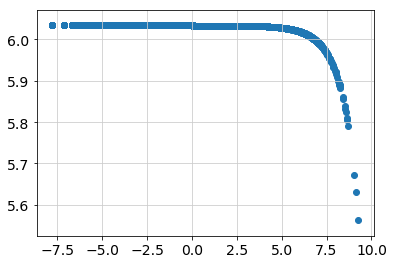

In [130]:
plt.scatter(np.log(xfit),np.log(yfit))


In [229]:
sum(y==y)

22981

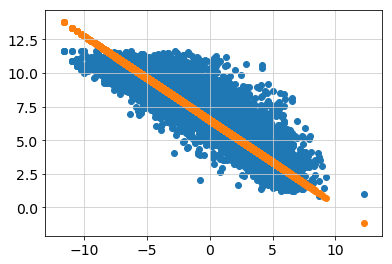

In [230]:
from sklearn.linear_model import LinearRegression
# import matplotlib
# matplotlib.use('qt5agg')

# import matplotlib.pyplot as plt
# import numpy as np

# # Create random data
# randomNumberGenerator = np.random.RandomState(1000)
# x = 4 * randomNumberGenerator.rand(100)
# y = 4 * x - 1 + randomNumberGenerator.randn(100)

# Create model
aux = (y==y)
model = LinearRegression()
model.fit(x[aux].reshape(-1, 1), y[aux].reshape(-1, 1))

xfit = x[aux].reshape(-1, 1) #np.linspace(0, 5, 50)
yfit = model.predict(xfit)

# plot
plt.scatter(x[aux], y[aux])
plt.scatter(xfit,yfit)
plt.show()



In [247]:
gene_names[y<yfit.flatten()*.5]

Index(['Fau', 'Gm20594', 'Gm5506', 'Gm6682', 'Mir682', 'Mir684-1', 'Mir703',
       'Ndufs5', 'Rpl12', 'Rpl19', 'Rpl23', 'Rpl23a', 'Rpl27a', 'Rpl34-ps1',
       'Rpl37', 'Rpl38', 'Rpl39', 'Rpl5', 'Rps21', 'Rps23', 'Rps24', 'Rps27',
       'Rps29', 'Rps6', 'Sumo2', 'Tomm7'],
      dtype='object', name='index')

In [199]:
xfit.flatten()

array([-3.342122 ,  5.0063224,  4.100098 , ...,  3.165173 , -2.7725887,
        2.6798325], dtype=float32)

In [202]:
y

array([6.538854 , 0.703092 , 1.3695887, ..., 2.5246325, 6.5283427,
       2.6295142], dtype=float32)

In [184]:
xfitflat = xfit.flatten()
xfitflat.shape

(19525,)

In [194]:
xfitflat,xflat

(array([-3.342122 ,  5.0063224,  4.100098 , ...,  3.165173 , -2.7725887,
         2.6798325], dtype=float32),
 array([-3.342122 ,  5.0063224,  4.100098 , ...,  3.165173 , -2.7725887,
         2.6798325], dtype=float32))

In [188]:
xflat = x[aux]
xflat.shape

(19525,)

In [193]:
sum(xflat<xfitflat)

0

In [114]:
y

array([691.4938   ,   2.0199888,   3.9337327, ...,  12.486305 ,
       684.2632   ,  13.867033 ], dtype=float32)

In [66]:
plt.plot(np.log(bladder.X.todense().mean(axis=0).transpose()),
         np.log(bladder.X.todense().var(axis=0).transpose())/np.log(bladder.X.todense().mean(axis=0).transpose())^2)

# cv2 <- vars/means^2


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [39]:
sns.scatterplot(bladder.X.todense().mean(axis=0).transpose(), bladder.X.todense().var(axis=0).transpose())

ValueError: If using all scalar values, you must pass an index

In [239]:
adata.raw.X

<110824x23335 sparse matrix of type '<class 'numpy.float32'>'
	with 293336076 stored elements in Compressed Sparse Row format>

normalization & scaling
normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


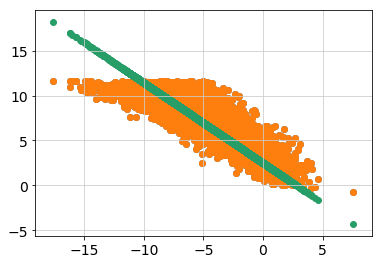

In [241]:
print('normalization & scaling')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
xnorm = np.log(np.array(adata.X.todense().mean(axis=0).transpose()).flatten())
ynorm = np.log(np.array(adata.X.todense().var(axis=0).transpose()).flatten()/np.array(adata.X.todense().mean(axis=0).transpose()).flatten()**2)
xnorm = xnorm[ynorm==ynorm]
gene_names_norm = adata.var_names[ynorm==ynorm]
ynorm = ynorm[ynorm==ynorm]
plt.scatter(xnorm,ynorm)

# Create model
aux = (ynorm==ynorm)
model = LinearRegression()
model.fit(xnorm[aux].reshape(-1, 1), ynorm[aux].reshape(-1, 1))

xfitnorm = xnorm[aux].reshape(-1, 1) #np.linspace(0, 5, 50)
yfitnorm = model.predict(xfitnorm)

# plot
plt.scatter(xnorm[aux], ynorm[aux])
plt.scatter(xfitnorm,yfitnorm)
plt.show()

In [242]:
gene_names_norm[ynorm<yfitnorm.flatten()*.5]

Index(['1810006K21Rik', 'Arf1', 'Atp5l', 'Atp6v0c', 'Btf3', 'Cdc42', 'Cdk2ap1',
       'Chchd2', 'Cnbp', 'Ddx5',
       ...
       'Tpt1', 'Uba52', 'Ubb', 'Ubc', 'Ube2d3', 'Ube2i', 'Ube2n', 'Ube2v1',
       'Ywhae', 'Ywhaz'],
      dtype='object', name='index', length=102)

extracting highly variable genes
    finished (0:00:04)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


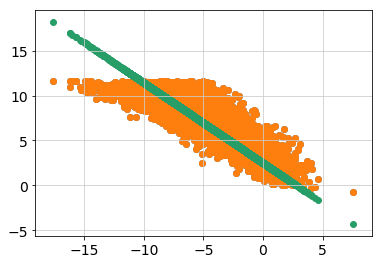

Index(['1810006K21Rik', 'Arf1', 'Atp5l', 'Atp6v0c', 'Btf3', 'Cdc42', 'Cdk2ap1',
       'Chchd2', 'Cnbp', 'Ddx5',
       ...
       'Tpt1', 'Uba52', 'Ubb', 'Ubc', 'Ube2d3', 'Ube2i', 'Ube2n', 'Ube2v1',
       'Ywhae', 'Ywhaz'],
      dtype='object', name='index', length=102)

In [243]:
adata = sc.pp.filter_genes_dispersion(adata, subset = False, min_disp=.5, max_disp=None, 
                          min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None, 
                          log=True, copy=True)

xfilter = np.log(np.array(adata.X.todense().mean(axis=0).transpose()).flatten())
yfilter = np.log(np.array(adata.X.todense().var(axis=0).transpose()).flatten()/np.array(adata.X.todense().mean(axis=0).transpose()).flatten()**2)
xfilter = xfilter[yfilter==yfilter]
gene_names_filter = adata.var_names[yfilter==yfilter]
yfilter = yfilter[yfilter==yfilter]
plt.scatter(xfilter,yfilter)

# Create model
aux = (yfilter==yfilter)
model = LinearRegression()
model.fit(xfilter[aux].reshape(-1, 1), yfilter[aux].reshape(-1, 1))

xfitfilter = xfilter[aux].reshape(-1, 1) #np.linspace(0, 5, 50)
yfitfilter = model.predict(xfitfilter)

# plot
plt.scatter(xfilter[aux], yfilter[aux])
plt.scatter(xfitfilter,yfitfilter)
plt.show()


gene_names_filter[yfilter<yfitfilter.flatten()*.5]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


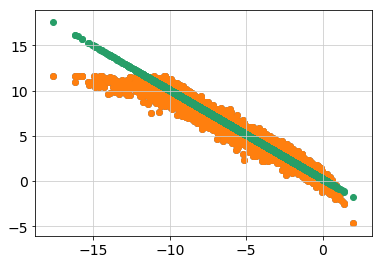

Index(['1110003E01Rik', '1500032L24Rik', '1810006K21Rik', '1810037I17Rik',
       '2010107E04Rik', '2310003F16Rik', '2410015M20Rik', '6720456B07Rik',
       'Actb', 'Actg1',
       ...
       'Vcp', 'Vdac2', 'Ybx1', 'Ywhab', 'Ywhae', 'Ywhah', 'Ywhaq', 'Ywhaz',
       'Zfp36l1', 'Zfp706'],
      dtype='object', name='index', length=467)

In [244]:
sc.pp.log1p(adata)
xlog = np.log(np.array(adata.X.todense().mean(axis=0).transpose()).flatten())
ylog = np.log(np.array(adata.X.todense().var(axis=0).transpose()).flatten()/np.array(adata.X.todense().mean(axis=0).transpose()).flatten()**2)
xlog = xlog[ylog==ylog]
gene_names_log = adata.var_names[ylog==ylog]
ylog = ylog[ylog==ylog]
plt.scatter(xlog,ylog)

# Create model
aux = (ylog==ylog)
model = LinearRegression()
model.fit(xlog[aux].reshape(-1, 1), ylog[aux].reshape(-1, 1))

xfitlog = xlog[aux].reshape(-1, 1) #np.linspace(0, 5, 50)
yfitlog = model.predict(xfitlog)

# plot
plt.scatter(xlog[aux], ylog[aux])
plt.scatter(xfitlog,yfitlog)
plt.show()


gene_names_log[ylog<yfitlog.flatten()*.5]

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


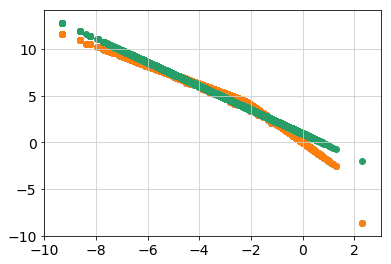

Index(['0610007C21Rik', '0610009D07Rik', '0610031J06Rik', '1110002B05Rik',
       '1110003E01Rik', '1110008F13Rik', '1500032L24Rik', '1810006K21Rik',
       '1810037I17Rik', '2310003F16Rik',
       ...
       'Ywhae', 'Ywhah', 'Ywhaq', 'Ywhaz', 'Zfand5', 'Zfp187', 'Zfp207',
       'Zfp36', 'Zfp36l1', 'Zfp706'],
      dtype='object', name='index', length=783)

In [246]:
sc.pp.scale(adata, max_value=10, zero_center=False)
xscale = np.log(np.array(adata.X.todense().mean(axis=0).transpose()).flatten())
yscale = np.log(np.array(adata.X.todense().var(axis=0).transpose()).flatten()/np.array(adata.X.todense().mean(axis=0).transpose()).flatten()**2)
xscale = xscale[yscale==yscale]
gene_names_scale = adata.var_names[yscale==yscale]
yscale = yscale[yscale==yscale]
plt.scatter(xscale,yscale)

# Create model
aux = (yscale==yscale)
model = LinearRegression()
model.fit(xscale[aux].reshape(-1, 1), yscale[aux].reshape(-1, 1))

xfitscale = xscale[aux].reshape(-1, 1) #np.linspace(0, 5, 50)
yfitscale = model.predict(xfitscale)

# plot
plt.scatter(xscale[aux], yscale[aux])
plt.scatter(xfitscale,yfitscale)
plt.show()


gene_names_scale[yscale<yfitscale.flatten()*.5]

In [248]:
set(gene_names[y<yfit.flatten()*.5])&set(
    gene_names_norm[ynorm<yfitnorm.flatten()*.5])&set(
    gene_names_filter[yfilter<yfitfilter.flatten()*.5])&set(
    gene_names_log[ylog<yfitlog.flatten()*.5])&set(gene_names_scale[yscale<yfitscale.flatten()*.5])

{'Mir682',
 'Rpl12',
 'Rpl19',
 'Rpl23',
 'Rpl23a',
 'Rpl27a',
 'Rpl34-ps1',
 'Rpl37',
 'Rpl39',
 'Rpl5',
 'Rps21',
 'Rps24',
 'Rps27',
 'Rps29',
 'Rps6',
 'Sumo2'}

In [249]:
gene_names[y<yfit.flatten()*.5]

Index(['Fau', 'Gm20594', 'Gm5506', 'Gm6682', 'Mir682', 'Mir684-1', 'Mir703',
       'Ndufs5', 'Rpl12', 'Rpl19', 'Rpl23', 'Rpl23a', 'Rpl27a', 'Rpl34-ps1',
       'Rpl37', 'Rpl38', 'Rpl39', 'Rpl5', 'Rps21', 'Rps23', 'Rps24', 'Rps27',
       'Rps29', 'Rps6', 'Sumo2', 'Tomm7'],
      dtype='object', name='index')

In [240]:
# adata.uns['tissue_colors'] = list(maca_color_dict.values())


# print('pca')
# sc.tl.pca(adata,svd_solver='arpack')
# sc.pl.pca_overview(adata)
# # adata_nonans = adata.copy()
# # adata_nonans = adata_nonans[adata_nonans.obs['cell_ontology_class_reannotated']!='nan']


# print('neighs')
# sc.pp.neighbors(adata)#, n_neighbors=25, n_pcs=20)


# print('umap computing')
# sc.tl.umap(adata,n_components=2)
# adata.uns['age_colors'] = list(age_color_dict.values())
# sc.pl.umap(adata,color='tissue')#,projection='3d',save='_maca_facs_3d_tissue.pdf')
# sc.pl.umap(adata,color='age')#,projection='3d', save='_maca_facs_3d_age.pdf')

# print('clustering')
# sc.tl.louvain(adata)#, resolution = 5)
# sc.tl.leiden(adata)#, resolution = 5)

# sc.pl.umap(adata,color=['louvain'], legend_loc='on data')

normalization & scaling
normalizing by total count per cell
    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [3]:
counts = adata_ercc_counts.X.todense()
counts = pd.DataFrame(counts,index = adata_ercc_counts.obs_names,
                      columns=adata_ercc_counts.var_names)

genes_tissue_dict = {}
for t in list(set(adata_ercc_counts.obs['tissue'])):
    adata_aux = adata_ercc_counts[adata_ercc_counts.obs['tissue']==t]
    if t == 'Mammary_Gland':
        adata_aux3 = adata_aux[adata_aux.obs['age']=='3m']
        counts_aux3 = counts.loc[adata_aux3.obs_names]
        
        counts_aux3.loc['sum'] = counts_aux3.astype(bool).sum(axis=0)
        
        a3 = counts_aux3.loc['sum']>counts_aux3.shape[0]*3/4
        a3 = list(a3[a3==True].index)
        
        adata_aux18 = adata_aux[adata_aux.obs['age']=='18m']
        counts_aux18 = counts.loc[adata_aux18.obs_names]
        
        counts_aux18.loc['sum'] = counts_aux18.astype(bool).sum(axis=0)
        
        a18 = counts_aux18.loc['sum']>counts_aux18.shape[0]*3/4
        a18 = list(a18[a18==True].index)
        
        adata_aux21 = adata_aux[adata_aux.obs['age']=='21m']
        counts_aux21 = counts.loc[adata_aux21.obs_names]
        
        counts_aux21.loc['sum'] = counts_aux21.astype(bool).sum(axis=0)
        
        a21 = counts_aux21.loc['sum']>counts_aux21.shape[0]*3/4
        a21 = list(a21[a21==True].index)
        
        genes_tissue_dict[t] = list(set(a3) & set(a18) & set(a21))
    else:
        adata_aux3 = adata_aux[adata_aux.obs['age']=='3m']
        counts_aux3 = counts.loc[adata_aux3.obs_names]
        
        counts_aux3.loc['sum'] = counts_aux3.astype(bool).sum(axis=0)
        
        a3 = counts_aux3.loc['sum']>counts_aux3.shape[0]*3/4
        a3 = list(a3[a3==True].index)
        
        adata_aux18 = adata_aux[adata_aux.obs['age']=='18m']
        counts_aux18 = counts.loc[adata_aux18.obs_names]
        
        counts_aux18.loc['sum'] = counts_aux18.astype(bool).sum(axis=0)
        
        a18 = counts_aux18.loc['sum']>counts_aux18.shape[0]*3/4
        a18 = list(a18[a18==True].index)
        
        adata_aux24 = adata_aux[adata_aux.obs['age']=='24m']
        counts_aux24 = counts.loc[adata_aux24.obs_names]
        
        counts_aux24.loc['sum'] = counts_aux24.astype(bool).sum(axis=0)
        a24 = counts_aux24.loc['sum']>counts_aux24.shape[0]*3/4
        a24 = list(a24[a24==True].index)
        
        genes_tissue_dict[t] = list(set(a3) & set(a18) & set(a24))

del counts

for t in list(set(adata_ercc_counts.obs['tissue'])):
    print(t,len(genes_tissue_dict[t]))

NameError: name 'adata_ercc_counts' is not defined